In [1]:
import numpy as np
import pandas as pd

In [2]:
pip install transformers

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
import numpy as np
from tqdm import tqdm, trange
data = pd.read_csv(r"/content/drive/MyDrive/all_in_one.csv", encoding='utf-8')
data = data.fillna(method='ffill')
data.head(50)

,Sentence ID,Word,Tag
0,1,The,O
1,1,admin@338,B-HackOrg
2,1,has,O
3,1,largely,O
4,1,targeted,O
5,1,organizations,O
6,1,involved,O
7,1,in,O
8,1,financial,B-Idus
9,1,",",O


In [7]:
class SentenceGetter(object):

    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence ID").apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["{}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [8]:
getter = SentenceGetter(data)

In [9]:
sentences = [[word[0] for word in sentence] for sentence in getter.sentences]
sentences[0]

['The',
 'admin@338',
 'has',
 'largely',
 'targeted',
 'organizations',
 'involved',
 'in',
 'financial',
 ',',
 'economic',
 'and',
 'trade',
 'policy',
 ',',
 'typically',
 'using',
 'publicly',
 'available',
 'RATs',
 'such',
 'as',
 'Poison',
 'Ivy',
 ',',
 'as',
 'well',
 'some',
 'non-public',
 'backdoors',
 '.']

In [10]:
labels = [[s[1] for s in sentence] for sentence in getter.sentences]
print(labels[0])

['O', 'B-HackOrg', 'O', 'O', 'O', 'O', 'O', 'O', 'B-Idus', 'O', 'B-Idus', 'O', 'B-Idus', 'I-Idus', 'O', 'O', 'O', 'B-Tool', 'I-Tool', 'I-Tool', 'O', 'O', 'B-Tool', 'I-Tool', 'O', 'O', 'O', 'O', 'B-Tool', 'I-Tool', 'O']


In [12]:
tag_values = list(set(data["Tag"].values))
tag_values.append("PAD")
tag2idx = {t: i for i, t in enumerate(tag_values)}

print(tag_values)

print(tag2idx)

['B-SecTeam', 'B-Tool', 'I-Time', 'B-Area', 'I-Purp', 'B-SamFile', 'B-HackOrg', 'I-SamFile', 'B-Org', 'I-Tool', 'B-Time', 'I-OffAct', 'I-SecTeam', 'B-Exp', 'I-Org', 'I-HackOrg', 'O', 'I-Area', 'B-Way', 'B-Features', 'B-OffAct', 'I-Exp', 'B-Idus', 'I-Features', 'I-Way', 'B-Purp', 'I-Idus', 'PAD']
{'B-SecTeam': 0, 'B-Tool': 1, 'I-Time': 2, 'B-Area': 3, 'I-Purp': 4, 'B-SamFile': 5, 'B-HackOrg': 6, 'I-SamFile': 7, 'B-Org': 8, 'I-Tool': 9, 'B-Time': 10, 'I-OffAct': 11, 'I-SecTeam': 12, 'B-Exp': 13, 'I-Org': 14, 'I-HackOrg': 15, 'O': 16, 'I-Area': 17, 'B-Way': 18, 'B-Features': 19, 'B-OffAct': 20, 'I-Exp': 21, 'B-Idus': 22, 'I-Features': 23, 'I-Way': 24, 'B-Purp': 25, 'I-Idus': 26, 'PAD': 27}


In [13]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler,Dataset
from transformers import BertTokenizer, BertConfig

from keras.utils import pad_sequences
from sklearn.model_selection import train_test_split

torch.__version__

'2.2.1+cu121'

In [14]:
MAX_LEN = 75
bs = 32
#batch size = bs
# sentence length fixed to 75 i.e. 75 tokens

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

In [16]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [17]:
def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels

In [18]:
tokenized_texts_and_labels = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(sentences, labels)
]

In [19]:
tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]

In [20]:
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

In [21]:
tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

In [22]:
attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]

In [23]:
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags,
                                                            random_state=2018, test_size=0.2)
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.2)

In [24]:
# convert to torch tenors
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)

In [25]:
#training time shuffling of the data and testing time we pass them sequentially
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)

In [26]:
import transformers
from transformers import BertForTokenClassification, AdamW

transformers.__version__

'4.40.2'

In [27]:
model = BertForTokenClassification.from_pretrained(
    "bert-base-cased",
    num_labels=len(tag2idx),
    output_attentions = False,
    output_hidden_states = False
)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [28]:
model.to(device)

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, el

In [29]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.001},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=1e-4,
    eps=1e-8
)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [30]:
#schduler to reduce learning rate linearly throughout the epochs
from transformers import get_linear_schedule_with_warmup

epochs = 10
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

In [31]:
!pip install seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=dcbde3e1b236e2be111f481fb1856e13fe81ad29cc568e067a3de28824bb1667
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [32]:
from seqeval.metrics import f1_score

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=2).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [33]:
loss_values, validation_loss_values = [], []

for _ in trange(epochs, desc="Epoch"):

    model.train()
    total_loss = 0

    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        model.zero_grad()
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        loss = outputs[0]
        loss.backward()
        total_loss += loss.item()
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_loss / len(train_dataloader)
    print("Average train loss: {}".format(avg_train_loss))

    loss_values.append(avg_train_loss)


    model.eval()
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)

        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        eval_loss += outputs[0].mean().item()
        eval_accuracy += flat_accuracy(logits, label_ids)
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

        nb_eval_examples += b_input_ids.size(0)
        nb_eval_steps += 1

    eval_loss = eval_loss / nb_eval_steps
    validation_loss_values.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))
    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
    valid_tags = [tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i] != "PAD"]

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Average train loss: 0.3855979018139117


Epoch:  10%|█         | 1/10 [01:11<10:40, 71.14s/it]

Validation loss: 0.21074708302815756
Validation Accuracy: 0.9365059523809522
Average train loss: 0.1405639837637092


Epoch:  20%|██        | 2/10 [02:23<09:35, 71.93s/it]

Validation loss: 0.14578055945180712
Validation Accuracy: 0.9576865079365081
Average train loss: 0.0762968699363145


Epoch:  30%|███       | 3/10 [03:37<08:29, 72.84s/it]

Validation loss: 0.12996148947803748
Validation Accuracy: 0.964686507936508
Average train loss: 0.04759565618905154


Epoch:  40%|████      | 4/10 [04:53<07:23, 73.97s/it]

Validation loss: 0.1363367848098278
Validation Accuracy: 0.9663511904761903
Average train loss: 0.02928671304588065


Epoch:  50%|█████     | 5/10 [06:09<06:14, 74.88s/it]

Validation loss: 0.1340542949203934
Validation Accuracy: 0.9698849206349206
Average train loss: 0.019922570762873598


Epoch:  60%|██████    | 6/10 [07:26<05:02, 75.68s/it]

Validation loss: 0.14192938511925085
Validation Accuracy: 0.9704404761904764
Average train loss: 0.013409768883138894


Epoch:  70%|███████   | 7/10 [08:43<03:48, 76.05s/it]

Validation loss: 0.14413902296551637
Validation Accuracy: 0.9713511904761902
Average train loss: 0.009455452105877074


Epoch:  80%|████████  | 8/10 [10:00<02:32, 76.30s/it]

Validation loss: 0.14999543494057088
Validation Accuracy: 0.9720892857142859
Average train loss: 0.007076024498338952


Epoch:  90%|█████████ | 9/10 [11:17<01:16, 76.48s/it]

Validation loss: 0.15650440042927152
Validation Accuracy: 0.9719603174603174
Average train loss: 0.006178479480811141


Epoch: 100%|██████████| 10/10 [12:34<00:00, 75.43s/it]

Validation loss: 0.15846172915328116
Validation Accuracy: 0.9725357142857143


In [34]:
from sklearn.metrics import classification_report
print(classification_report(valid_tags, pred_tags))

              precision    recall  f1-score   support

      B-Area       0.88      0.90      0.89       641
       B-Exp       0.99      0.99      0.99      1439
  B-Features       0.90      0.97      0.93       326
   B-HackOrg       0.89      0.91      0.90      2404
      B-Idus       0.86      0.86      0.86       481
    B-OffAct       0.84      0.84      0.84       560
       B-Org       0.80      0.79      0.80       419
      B-Purp       0.82      0.85      0.83       271
   B-SamFile       0.93      0.95      0.94      1050
   B-SecTeam       0.97      0.94      0.95       731
      B-Time       0.88      0.92      0.90       360
      B-Tool       0.86      0.87      0.86      1849
       B-Way       0.87      0.79      0.83       462
      I-Area       0.86      0.78      0.82       208
       I-Exp       0.99      0.88      0.93       178
  I-Features       0.92      0.96      0.94       422
   I-HackOrg       0.84      0.87      0.85       485
      I-Idus       0.83    

In [35]:
p = []
t = []
for i in pred_tags:
  if i == 'O':
    p.append(i)
  else:
    p.append(i[2:])

for i in valid_tags:
  if i == 'O':
    t.append(i)
  else:
    t.append(i[2:])

In [36]:
from sklearn.metrics import classification_report
print(classification_report(t, p))

              precision    recall  f1-score   support

        Area       0.90      0.89      0.89       849
         Exp       0.99      0.98      0.99      1617
    Features       0.92      0.97      0.94       748
     HackOrg       0.89      0.90      0.90      2889
        Idus       0.86      0.85      0.85       631
           O       0.97      0.96      0.97     31677
      OffAct       0.86      0.84      0.85       832
         Org       0.82      0.82      0.82       710
        Purp       0.84      0.87      0.86       661
     SamFile       0.94      0.95      0.94      1252
     SecTeam       0.94      0.94      0.94       898
        Time       0.93      0.95      0.94       604
        Tool       0.84      0.88      0.86      2432
         Way       0.87      0.81      0.84       765

    accuracy                           0.94     46565
   macro avg       0.90      0.90      0.90     46565
weighted avg       0.94      0.94      0.94     46565



In [37]:
report = classification_report(t, p, digits=4, output_dict=True)
# Access the weighted F1 score, recall, and precision
f1_weighted = report['weighted avg']['f1-score']

recall_weighted = report['weighted avg']['recall']
precision_weighted = report['weighted avg']['precision']

# Print the results

print ('Weighted F1 Score: ', f1_weighted)
print ('Weighted Recall: ', recall_weighted)
print ('Weighted Precision: ', precision_weighted)

Weighted F1 Score:  0.943783422701178
Weighted Recall:  0.9436916138730806
Weighted Precision:  0.944027892237967


In [38]:
report = classification_report(t, p, digits=4, output_dict=True)
# Access the weighted F1 score, recall, and precision
f1_weighted = report['macro avg']['f1-score']

recall_weighted = report['macro avg']['recall']
precision_weighted = report['macro avg']['precision']

# Print the results

print ('Macro F1 Score: ', f1_weighted)
print ('Macro Recall: ', recall_weighted)
print ('Macro Precision: ', precision_weighted)

Macro F1 Score:  0.8985805450602109
Macro Recall:  0.9003982819342886
Macro Precision:  0.8972251245898282


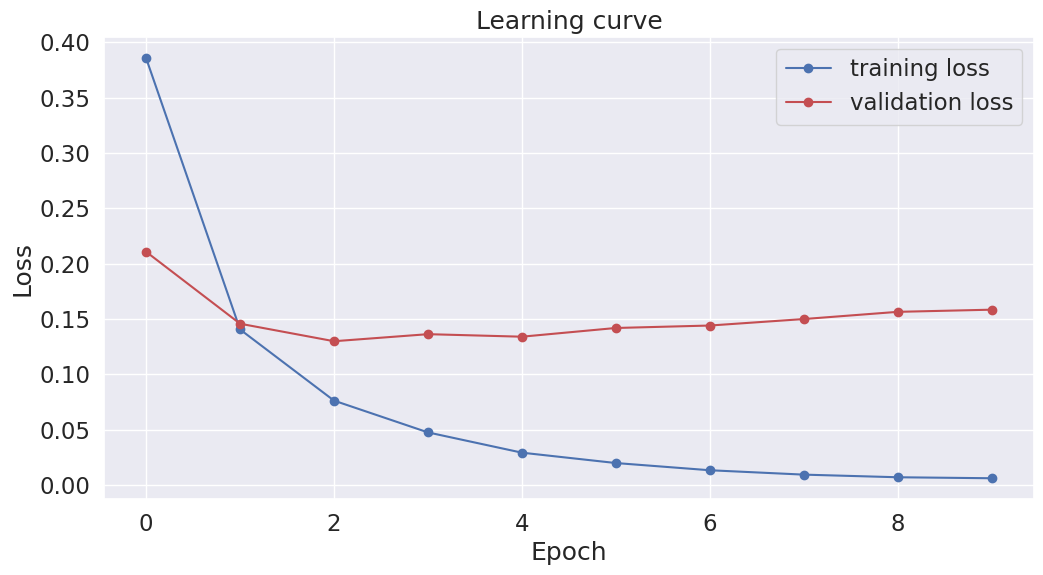

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [40]:
test_sentence = """
In October 2022, we identified an active infection of government, agriculture\
 and transportation organizations located in the Donetsk, Lugansk, and Crimea regions. Although the initial vector of compromise is unclear, the details of the next stage imply the use of spear phishing or similar methods.\
 The victims navigated to a URL pointing to a ZIP archive hosted on a malicious web server.
 """

In [41]:
tokenized_sentence = tokenizer.encode(test_sentence)
input_ids = torch.tensor([tokenized_sentence]).cuda()

In [42]:
with torch.no_grad():
    output = model(input_ids)
label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

In [43]:
# join bpe split tokens
tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
new_tokens, new_labels = [], []
for token, label_idx in zip(tokens, label_indices[0]):
    if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        new_labels.append(tag_values[label_idx])
        new_tokens.append(token)

In [44]:
for token, label in zip(new_tokens, new_labels):
  if token == '[CLS]' or token == '[SEP]':
    pass
  else:
    print("{:20}\t{}".format(token, label))

In                  	O
October             	B-Time
2022                	I-Time
,                   	O
we                  	O
identified          	O
an                  	O
active              	O
infection           	O
of                  	O
government          	B-Idus
,                   	O
agriculture         	B-Idus
and                 	O
transportation      	B-Idus
organizations       	I-Org
located             	O
in                  	O
the                 	O
Donetsk             	O
,                   	O
Lugansk             	B-Area
,                   	O
and                 	O
Crimea              	O
regions             	O
.                   	O
Although            	O
the                 	O
initial             	O
vector              	O
of                  	O
compromise          	O
is                  	O
unclear             	O
,                   	O
the                 	O
details             	O
of                  	O
the                 	O
next                	O
stage               	O
